In [2]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

import networkx as nx
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

from bokeh.io import show, output_file
from bokeh.plotting import figure, save
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Spectral4

from IPython.display import IFrame

%matplotlib inline

# <span style="color:#0000CD">  Path Analysis  </span> 

## Objectives:  
### - Key Terms  
### - Path Example  
### - Shortest Path: Dijkstra

## <span style="color:#0000CD"> Key Terms </span>

**Path**  

&nbsp;&nbsp;&nbsp;&nbsp;A single node or an ordered list of distinct nodes $n_i...n_k$ such that $(n_{i-1},n_k)$ is an edge for all $2$ $\leq$ $i$ $\leq$ $k$.

**Shortest Path**  

&nbsp;&nbsp;&nbsp;&nbsp;Finding a path between two nodes in a graph such that the sum of the weights along that path is minimized also known as a graph geodesic. For a directed graph the direction of the edges must be followed. 

**Distance**  

&nbsp;&nbsp;&nbsp;&nbsp;Number of edges in the shortest path between two nodes. 

## <span style="color:#0000CD"> Path Example  </span>

Paths from Daenerys Targaryen and Arya Stark in our Game of Thrones Character Interactions graph. 

In [5]:
G=nx.read_gpickle("../data/processed/got_graph.gpickle")

source='daenerys-targaryen'
target='arya-stark'

#all simple paths between mother of dragons and cersai 
fem_paths=nx.all_simple_paths(G, source, target, cutoff=2)
fem_paths = list(fem_paths)
print("Number of different paths of length three or less")
print("from Daenerys Targaryen to Arya Stark:")
print(len(fem_paths))

print(' ')
print("Possible Paths:")

for path in fem_paths:
     print(path)


nodes_fem_path = set(x for l in fem_paths for x in l)
FG=G.subgraph(nodes_fem_path)
FG.name = 'Subgraph of Paths Between Daenerys and Arya'

spring_pos = nx.fruchterman_reingold_layout(FG, scale=2, center=(0,0))
#spring_pos=nx.spectral_layout(FG, weight='weight', scale=3, center=(0,0))

print(' ')
print('Graph Summary:')
print(' ')
print(nx.info(FG))

Number of different paths of length three or less
from Daenerys Targaryen to Arya Stark:
4
 
Possible Paths:
['daenerys-targaryen', 'cersei-lannister', 'arya-stark']
['daenerys-targaryen', 'eddard-stark', 'arya-stark']
['daenerys-targaryen', 'robert-baratheon', 'arya-stark']
['daenerys-targaryen', 'tyrion-lannister', 'arya-stark']
 
Graph Summary:
 
Name: Subgraph of Paths Between Daenerys and Arya
Type: Graph
Number of nodes: 6
Number of edges: 14
Average degree:   4.6667


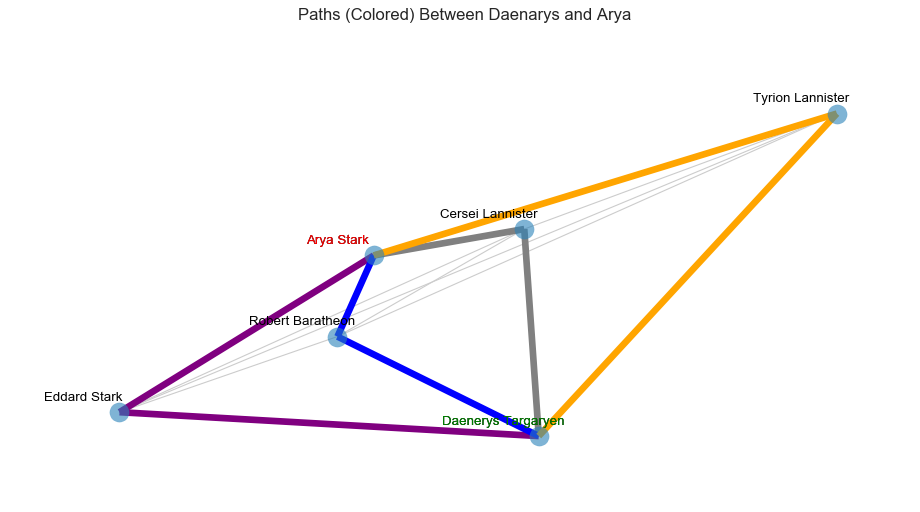

In [14]:
#Edges from routes
route_edges = fem_paths
edges=[]
for x in fem_paths:
    route_edges = [(x[n],x[n+1]) for n in range(len(x)-1)]
    edges.append(route_edges)

#Adjusting label position for nodes
pos_higher = {}
y_off = 0.01  # offset on the y axis
x_off = -0.1 # offset on the x axis
for k, v in spring_pos.items():
    pos_higher[k] = (v[0]+x_off, v[1]+y_off)
    
#Filtering to just source and target node labels
char_nodes = [source,target]
label_start={ key:value for key,value in nx.get_node_attributes(FG, name='Label').items() if key in char_nodes[0]}   
label_end={ key:value for key,value in nx.get_node_attributes(FG, name='Label').items() if key in char_nodes[1]} 

# plot the figure 
plt.figure(figsize=(14,7), dpi=80, frameon=False)
plt.suptitle("Paths (Colored) Between Daenarys and Arya", fontsize=15)
plt.axis('off')
# create the network layout


nx.draw_networkx_nodes(FG, pos=spring_pos, node_size=300, node_color=Spectral4[0], alpha=0.6)
#nx.draw_networkx_nodes(FG, pos=spring_pos, nodelist=char_nodes[0], node_color='green')
#nx.draw_networkx_nodes(FG, pos=spring_pos, nodelist=char_nodes[1], node_color='red')

nx.draw_networkx_labels(FG, pos=pos_higher, labels=nx.get_node_attributes(FG, name='Label'))
nx.draw_networkx_labels(FG, nodelist=char_nodes[0], pos=pos_higher, labels=label_start, font_color='green')
nx.draw_networkx_labels(FG, nodelist=char_nodes[1], pos=pos_higher, labels=label_end, font_color='red')


nx.draw_networkx_edges(FG, pos = spring_pos, edge_color="#CCCCCC", alpha=1.0)
nx.draw_networkx_edges(FG, pos=spring_pos, edgelist=edges[0], width=6, edge_color='grey')
nx.draw_networkx_edges(FG, pos=spring_pos, edgelist=edges[1], width=6, edge_color='purple')
nx.draw_networkx_edges(FG, pos=spring_pos, edgelist=edges[2], width=6, edge_color='blue')
nx.draw_networkx_edges(FG, pos=spring_pos, edgelist=edges[3], width=6, edge_color='orange')

plt.show()

##  <span style="color:#0000CD"> Shortest Path </span>

### Dijkstra's Shortest Path Algorithm

Invented by Edsger Dijkstra in 1956, it is an algorithm for finding the shortest path between any two nodes in a graph. Is also used to find the shortest paths between a starting node and every other node in a graph. 

Here's a simple graph to understand how the shortest path is calculated from node A to node F:  

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/Shortest_path_with_direct_weights.svg/250px-Shortest_path_with_direct_weights.svg.png" alt="Drawing" style="width: 400px"/>

Path: [A, C, E, D, F]  
Weight Sum: 20

The algorithm is an example of a greedy algorithm, meaning making the locally optimal choice at each stage with the hope of finding a global optimum.

There are several resources to understand the algorithm, this is a helpful [video](https://www.youtube.com/watch?v=pVfj6mxhdMw). 

Algorithm illustration from node a to node b:

<img src="https://upload.wikimedia.org/wikipedia/commons/5/57/Dijkstra_Animation.gif" alt="Drawing" style="width: 400px"/>

### Intro Characters Using Dijkstra's Shortest Path

What is the shortest path for introducing Arya and Daenerys taking into account the edge weights, or interaction counts? Since the algorithm **minimizes** weights, we are going to use the inverse value of the interaction counts because we would want to introduce the two characters through others they have interacted with often.

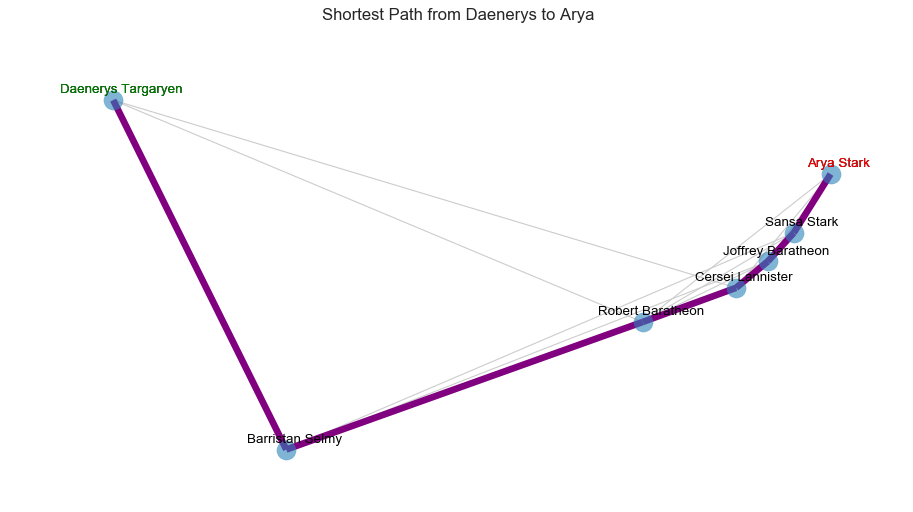

In [6]:
fem_short_path = nx.dijkstra_path(G, source,target, weight='weight_inv')

FG2=G.subgraph(fem_short_path)
#spring_pos=nx.fruchterman_reingold_layout(FG2, scale=3, center=(0,0))
spring_pos=nx.spectral_layout(FG2, weight='weight', scale=1, center=(0,0))


#Edges from routes
route_edges = []
for x in [fem_short_path]:
    route_edges = [(x[n],x[n+1]) for n in range(len(x)-1)]
    
#Adjusting label position for nodes
pos_higher = {}
y_off = 0.03  # offset on the y axis
x_off = 0.009 # offset on the x axis
for k, v in spring_pos.items():
    pos_higher[k] = (v[0]+x_off, v[1]+y_off)


# plot the figure 
plt.figure(figsize=(14,7), dpi=80, frameon=False)
plt.suptitle("Shortest Path from Daenerys to Arya", fontsize=15)
#plt.autoscale(enable=True, axis='both', tight=True)
plt.axis('off')
# create the network layout


nx.draw_networkx_nodes(FG2, pos=spring_pos, node_size=300, node_color=Spectral4[0], alpha=0.6)
nx.draw_networkx_labels(FG2, pos=pos_higher, labels=nx.get_node_attributes(FG2, name='Label'))
nx.draw_networkx_labels(FG2, nodelist=char_nodes[0], pos=pos_higher, labels=label_start, font_color='green')
nx.draw_networkx_labels(FG2, nodelist=char_nodes[1], pos=pos_higher, labels=label_end, font_color='red')


nx.draw_networkx_edges(FG2, pos = spring_pos, edge_color="#CCCCCC", alpha=1.0)
#nx.draw_networkx_edge_labels(FG2, pos = spring_pos )
nx.draw_networkx_edges(FG2, pos=spring_pos, edgelist=route_edges, width=6, edge_color='purple')
#nx.draw_networkx_edges(FG2, pos=spring_pos, edgelist=edges[1], width=6, edge_color='purple')

plt.show()

###  <span style="color:green">  Knowledge Check: </span>

***Why might this path be longer than the first example we shared?***